# DATASET INFO and PRE-PROCESSING

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats.mstats import winsorize
import datetime as dt

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

%matplotlib inline
# %matplotlib notebook

plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,SimpleRNN,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
df=pd.read_csv("energydata_complete.csv",index_col="date",parse_dates=True)

In [3]:
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000,19735.000,19735.000,19735.000,19735.000,19735.000,19735.000,19735.000,19735.000,19735.000,...,19735.000,19735.000,19735.000,19735.000,19735.000,19735.000,19735.000,19735.000,19735.000,19735.000
mean,97.695,3.802,21.687,40.260,20.341,40.420,22.268,39.243,20.855,39.027,...,19.486,41.552,7.412,755.523,79.750,4.040,38.331,3.761,24.988,24.988
std,102.525,7.936,1.606,3.979,2.193,4.070,2.006,3.255,2.043,4.341,...,2.015,4.151,5.317,7.399,14.901,2.451,11.795,4.195,14.497,14.497
min,10.000,0.000,16.790,27.023,16.100,20.463,17.200,28.767,15.100,27.660,...,14.890,29.167,-5.000,729.300,24.000,0.000,1.000,-6.600,0.005,0.005
25%,50.000,0.000,20.760,37.333,18.790,37.900,20.790,36.900,19.530,35.530,...,18.000,38.500,3.667,750.933,70.333,2.000,29.000,0.900,12.498,12.498
50%,60.000,0.000,21.600,39.657,20.000,40.500,22.100,38.530,20.667,38.400,...,19.390,40.900,6.917,756.100,83.667,3.667,40.000,3.433,24.898,24.898
75%,100.000,0.000,22.600,43.067,21.500,43.260,23.290,41.760,22.100,42.157,...,20.600,44.338,10.408,760.933,91.667,5.500,40.000,6.567,37.584,37.584
max,1080.000,70.000,26.260,63.360,29.857,56.027,29.236,50.163,26.200,51.090,...,24.500,53.327,26.100,772.300,100.000,14.000,66.000,15.500,49.997,49.997


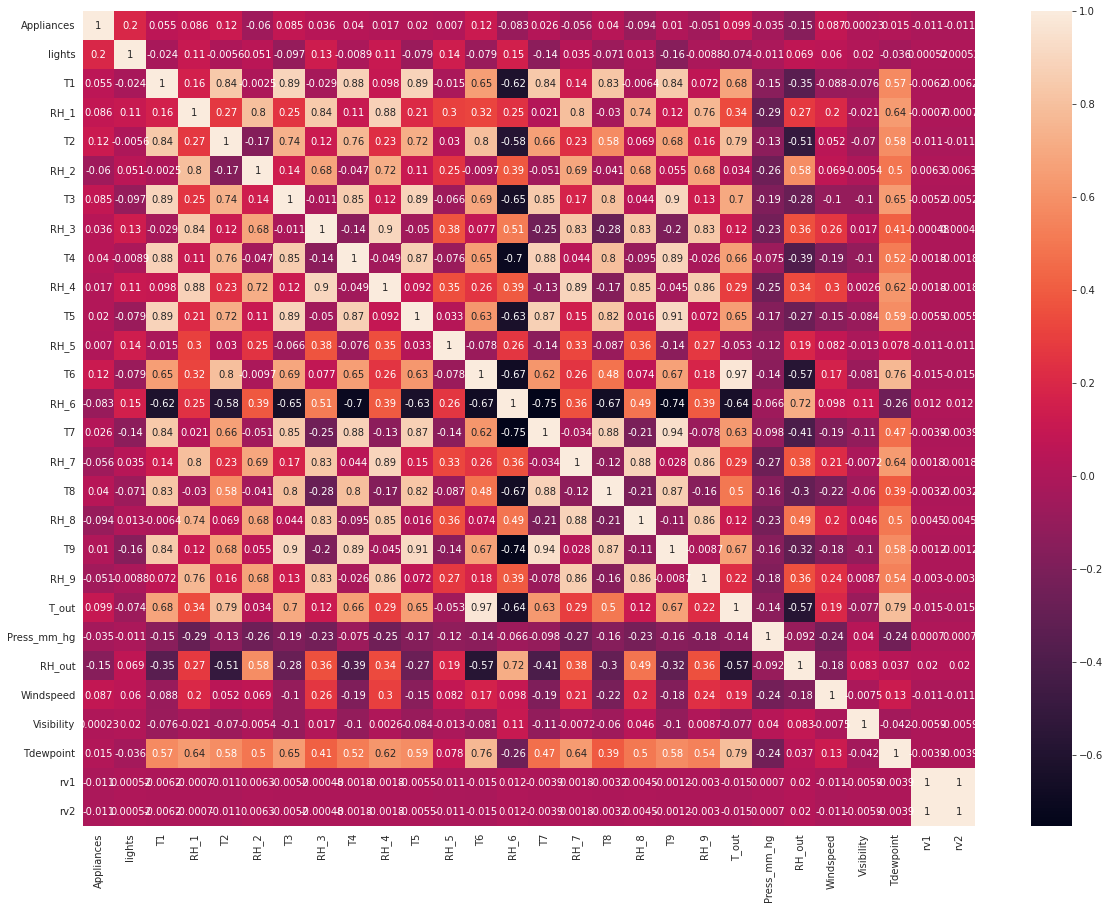

In [4]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(),annot=True);

In [5]:
df.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [6]:
df=df.rename(columns={"T6":"T_out","RH_6":"RH_outside"})
df["T_inside"]=(df["T1"]+df["T2"]+df["T3"]+df["T4"]+df["T5"]+df["T7"]+df["T8"]+df["T9"])/8
df["RH_inside"]=(df["RH_1"]+df["RH_2"]+df["RH_3"]+df["RH_4"]+df["RH_5"]+df["RH_7"]+df["RH_8"]+df["RH_9"])/8

In [7]:
df.drop(["T1","T2","T3","T4","T5","T7","T8","RH_1","RH_2","RH_3","RH_4","RH_5","RH_7","RH_8","RH_9","T9","RH_out","T_out","rv1","rv2"],axis=1,inplace=True)

In [8]:
df

,Appliances,lights,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,
2016-01-11 17:00:00,60,30,84.257,733.500,7.000,63.000,5.300,18.435,46.743
2016-01-11 17:10:00,60,30,84.063,733.600,6.667,59.167,5.200,18.439,46.673
2016-01-11 17:20:00,50,30,83.157,733.700,6.333,55.333,5.100,18.422,46.563
2016-01-11 17:30:00,50,40,83.423,733.800,6.000,51.500,5.000,18.396,46.469
2016-01-11 17:40:00,60,40,84.893,733.900,5.667,47.667,4.900,18.409,46.463
...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,1.000,755.200,3.333,23.667,13.333,24.870,46.138
2016-05-27 17:30:00,90,0,1.000,755.200,3.500,24.500,13.300,24.847,46.089
2016-05-27 17:40:00,270,10,1.000,755.200,3.667,25.333,13.267,24.819,46.238


In [9]:
df_a=df[["Appliances","lights"]]
df_b=df.drop(["Appliances","lights"],axis=1)

In [10]:
df_a=df_a.resample("H").sum() # Bir saatdeki toplam tüketip
df_b=df_b.resample("H").mean() # Ama burada ortalama mesela 10. dk 20 derece hava 20.dakika 40 olmatz ortalama olur


In [11]:
df=pd.concat([df_a,df_b],axis=1)

In [12]:
df

,Appliances,lights,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,
2016-01-11 17:00:00,330,210,84.260,733.750,6.167,53.417,5.050,18.415,46.555
2016-01-11 18:00:00,1060,310,87.204,734.267,5.417,40.000,4.658,18.408,46.520
2016-01-11 19:00:00,1040,150,88.131,734.792,6.000,40.000,4.392,18.686,48.665
2016-01-11 20:00:00,750,210,86.934,735.283,6.000,40.000,4.017,18.941,50.356
2016-01-11 21:00:00,620,140,86.129,735.567,6.000,40.000,3.817,19.254,48.977
...,...,...,...,...,...,...,...,...,...
2016-05-27 14:00:00,610,10,1.000,755.800,2.000,21.583,13.475,24.855,45.891
2016-05-27 15:00:00,460,0,1.000,755.675,2.000,21.833,13.258,24.838,45.416
2016-05-27 16:00:00,810,0,1.000,755.375,2.417,22.583,13.283,24.889,45.991


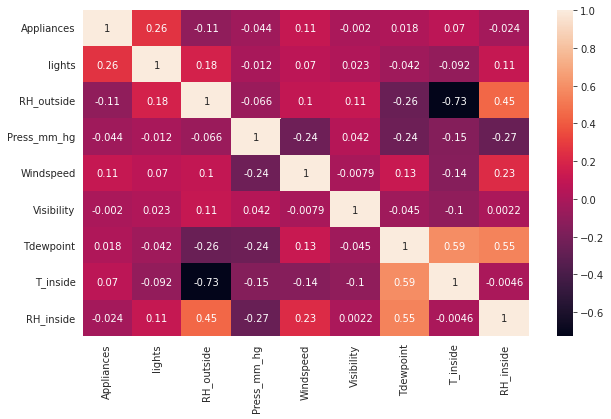

In [13]:
sns.heatmap(df.corr(),annot=True);

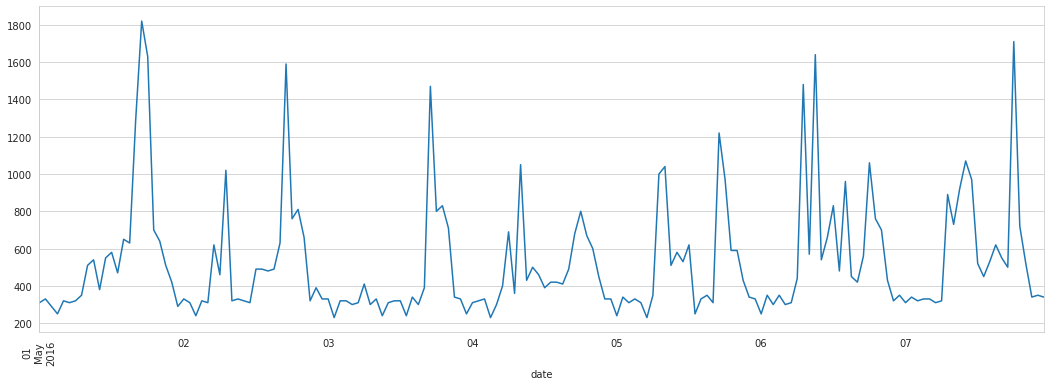

In [14]:
df["Appliances"].loc["2016-05-01 00:00:00":"2016-05-07"].plot(figsize=(18,6))
plt.xticks(rotation=90);

# Train and Test SPLIT

In [15]:
test_day=7 # 7 güne bakmak istiyorum, günde 24 saat var. 
test_ind=test_day*24

In [16]:
train=df.iloc[:-test_ind]
test=df.iloc[-test_ind:]

In [17]:
train.shape,test.shape

((3122, 9), (168, 9))

# Scaling

In [18]:
f_scaler=RobustScaler()
target_scaler=RobustScaler()

In [19]:
f_columns=df.columns[1:]

In [20]:
train.loc[:,f_columns]=f_scaler.fit_transform(train[f_columns])
train["Appliances"]=target_scaler.fit_transform(train[["Appliances"]])

test.loc[:,f_columns]=f_scaler.transform(test[f_columns])
test["Appliances"]=target_scaler.transform(test[["Appliances"]])

In [21]:
def  create(X,y,time_steps):
  Xs,ys=[],[]
  for i in range(len(X)-time_steps):
    v=X.iloc[i:(i+time_steps)].values
    Xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs),np.array(ys)

In [22]:
time_steps=24

X_train,y_train=create(train,train.Appliances, time_steps)
X_test,y_test=create(test,test.Appliances,time_steps)

In [23]:
y_test

array([ 0.77777778,  0.55555556,  1.22222222,  0.19444444,  1.44444444,
       -0.02777778, -0.08333333, -0.16666667, -0.13888889, -0.11111111,
       -0.19444444, -0.05555556,  0.02777778,  2.13888889,  0.86111111,
        2.33333333,  4.69444444,  1.08333333,  0.69444444,  0.75      ,
        0.58333333,  0.44444444,  3.38888889,  0.97222222,  0.58333333,
        0.91666667,  0.44444444,  0.27777778, -0.02777778, -0.05555556,
       -0.16666667, -0.05555556, -0.16666667, -0.19444444,  0.08333333,
       -0.02777778, -0.08333333, -0.16666667, -0.11111111, -0.16666667,
       -0.08333333,  0.        , -0.08333333, -0.05555556,  0.19444444,
        1.58333333,  5.30555556,  1.02777778,  0.97222222,  0.72222222,
        0.11111111,  0.02777778, -0.05555556, -0.19444444, -0.08333333,
       -0.11111111, -0.13888889, -0.13888889,  0.75      ,  0.16666667,
        1.66666667, -0.08333333, -0.38888889,  0.08333333,  0.66666667,
        1.11111111,  0.94444444,  1.47222222,  1.33333333,  1.33

In [24]:
n_features=X_train.shape[2]
n_features

9

In [25]:
from sklearn.utils import shuffle

# Modelling

In [26]:
model=Sequential()

model.add(Bidirectional(LSTM(units=100,input_shape=(time_steps,n_features))))

model.add(Dropout(rate=0.2))

model.add(Dense(1))

model.compile(optimizer="adam",loss="mse")


In [27]:
early=EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)

In [28]:
model.fit(X_train,y_train,
          epochs=30,
          batch_size=24,
          validation_split=0.3,     
      callbacks=[early])

Epoch 1/30
91/91 [==============================] - 14s 42ms/step - loss: 1.5319 - val_loss: 0.9091
Epoch 2/30
91/91 [==============================] - 3s 32ms/step - loss: 1.2512 - val_loss: 0.8573
Epoch 3/30
91/91 [==============================] - 3s 34ms/step - loss: 1.1773 - val_loss: 0.8500
Epoch 4/30
91/91 [==============================] - 3s 36ms/step - loss: 1.1566 - val_loss: 0.8529
Epoch 5/30
91/91 [==============================] - 3s 34ms/step - loss: 1.1248 - val_loss: 0.8369
Epoch 6/30
91/91 [==============================] - 3s 35ms/step - loss: 1.0998 - val_loss: 0.9149
Epoch 7/30
91/91 [==============================] - 3s 35ms/step - loss: 1.0885 - val_loss: 0.8920
Epoch 8/30
91/91 [==============================] - 3s 34ms/step - loss: 1.0272 - val_loss: 0.8400
Epoch 9/30
91/91 [==============================] - 3s 31ms/step - loss: 1.0191 - val_loss: 0.9792
Epoch 10/30
91/91 [==============================] - 3s 32ms/step - loss: 1.0002 - val_loss: 0.9914


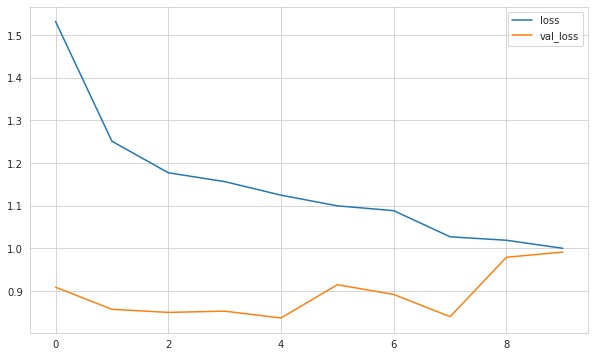

In [29]:
pd.DataFrame(model.history.history).plot();

# Evaluation on Test Data

In [30]:
def ev_metrics(act,pred):
  rmse = np.sqrt(mean_squared_error(act,pred))
  mae=mean_absolute_error(act,pred)
  mse=mean_squared_error(act,pred)
  score=r2_score(act,pred)
  return print("r2_score",score,"mae:",mse,"rmse:",rmse) 

In [31]:
y_pred=model.predict(X_test)

In [32]:
ev_metrics(y_test,y_pred)

r2_score 0.14188372547681294 mae: 1.4973136975367694 rmse: 1.2236477015615113


In [33]:
y_train_inv=target_scaler.inverse_transform(y_train.reshape(1,-1))
y_test_inv=target_scaler.inverse_transform(y_test.reshape(1,-1))
y_pred_inv=target_scaler.inverse_transform(y_pred)

In [34]:
test_index=test.iloc[time_steps:].index
pred_test=pd.concat([pd.DataFrame(y_test_inv.reshape(-1,1)),
                     pd.DataFrame(y_pred_inv)], axis=1)
pred_test.columns=["test","prediction"]
pred_test.index=test_index
pred_test

,test,prediction
date,,
2016-05-21 19:00:00,650.000,919.880
2016-05-21 20:00:00,570.000,726.768
2016-05-21 21:00:00,810.000,541.393
2016-05-21 22:00:00,440.000,457.487
2016-05-21 23:00:00,890.000,338.206
...,...,...
2016-05-27 14:00:00,610.000,901.781
2016-05-27 15:00:00,460.000,844.810
2016-05-27 16:00:00,810.000,779.033


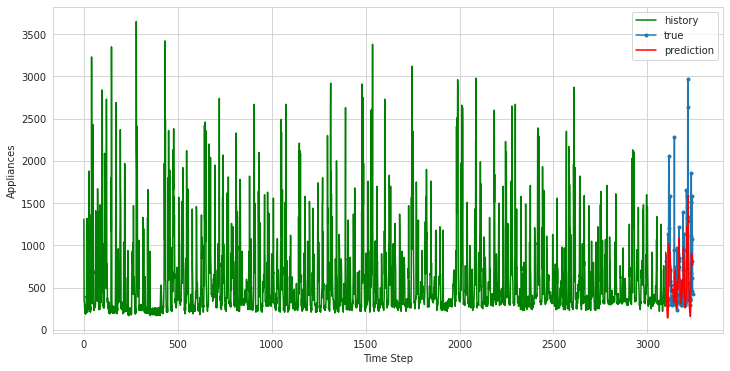

In [35]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0,len(y_train)),y_train_inv.flatten(),"g",label="history")
plt.plot(np.arange(len(y_train),len(y_train)+len(y_test)),y_test_inv.flatten(),marker=".",label="true")
plt.plot(np.arange(len(y_train),len(y_train)+len(y_test)),y_pred_inv.flatten(),"r",label="prediction")
plt.ylabel("Appliances")
plt.xlabel("Time Step")
plt.legend()
plt.show();

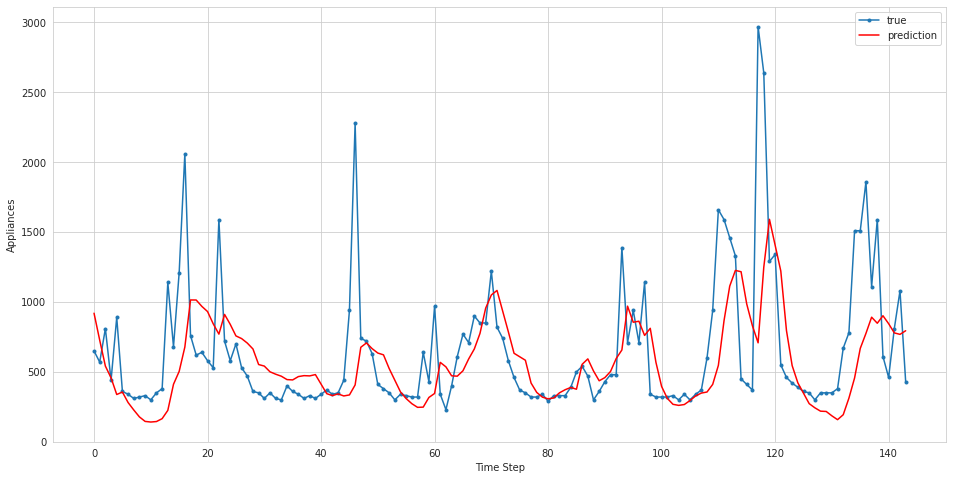

In [36]:
plt.figure(figsize=(16,8))
plt.plot(y_test_inv.flatten(),marker=".",label="true")
plt.plot(y_pred_inv.flatten(),"r",label="prediction")
plt.ylabel("Appliances")
plt.xlabel("Time Step")
plt.legend();


# Second was: after each prediction, result will be used for next prediction

In [37]:
train

,Appliances,lights,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,
2016-01-11 17:00:00,-0.111,10.500,0.525,-2.116,0.721,1.643,0.366,-1.064,1.100
2016-01-11 18:00:00,1.917,15.500,0.582,-2.067,0.512,0.000,0.291,-1.067,1.094
2016-01-11 19:00:00,1.861,7.500,0.600,-2.017,0.674,0.000,0.239,-0.926,1.479
2016-01-11 20:00:00,1.056,10.500,0.577,-1.970,0.674,0.000,0.167,-0.796,1.782
2016-01-11 21:00:00,0.694,7.000,0.562,-1.943,0.674,0.000,0.128,-0.636,1.535
...,...,...,...,...,...,...,...,...,...
2016-05-20 14:00:00,-0.028,0.000,-0.580,0.226,0.233,0.000,1.999,1.289,0.935
2016-05-20 15:00:00,-0.250,0.000,-0.790,0.220,0.279,0.000,1.874,1.341,0.941
2016-05-20 16:00:00,-0.222,0.000,-1.045,0.208,0.233,0.000,1.776,1.375,0.849


In [38]:
df_fake=test.iloc[:time_steps,1:]

In [61]:
reel=np.array(test.iloc[:time_steps,:1])
reel.reshape((1,-1))[0]

array([ 0.05555556,  0.13888889,  0.05555556, -0.13888889, -0.27777778,
       -0.22222222, -0.16666667, -0.08333333, -0.22222222, -0.08333333,
       -0.16666667, -0.02777778, -0.08333333,  2.44444444,  4.13888889,
        5.36111111,  6.16666667,  2.77777778,  4.69444444,  4.02777778,
        5.        ,  0.63888889,  0.55555556,  1.05555556])

In [62]:
df_fake.values

array([[ 0.        , -1.08219133,  0.19561195,  0.27906977,  0.        ,
         1.17703733,  1.49659672,  0.97593515],
       [ 0.        , -0.89815409,  0.2011631 , -0.11627907,  0.        ,
         1.15134484,  1.42052593,  0.79191987],
       [ 0.5       , -0.59815335,  0.20909331, -0.55813953,  0.        ,
         1.38418306,  1.36635202,  0.7669697 ],
       [ 0.5       , -0.43497898,  0.22019561, -0.72093023,  0.        ,
         1.48213569,  1.34642766,  0.82824215],
       [ 0.        , -0.28931606,  0.20830029, -0.60465116, -0.56122449,
         1.62986752,  1.31815013,  0.88945046],
       [ 0.        , -0.19341799,  0.17975152, -0.3255814 , -1.39795918,
         1.82898434,  1.29852077,  0.94094207],
       [ 0.        , -0.13115266,  0.14327254, -0.04651163, -0.85714286,
         1.83219591,  1.28415349,  0.96439785],
       [ 0.        , -0.12324018,  0.10362146,  0.11627907,  0.        ,
         1.82095544,  1.27349209,  0.97804579],
       [ 0.        , -0.1073802 

In [63]:
df_fake.values.reshape((df_fake.shape[0],1,df_fake.shape[1])).shape

(24, 1, 8)

In [64]:
n_features

9

In [65]:
prediction_scaled=[]
first_eval_batch=train.values[-time_steps:]
current_batch=first_eval_batch.reshape((1,time_steps,n_features))
features= df_fake.values.reshape((df_fake.shape[0],1,df_fake.shape[1]))

for i in range(time_steps):
  current_pred=model.predict(current_batch)
  prediction_scaled.append(current_pred[0])
  new=features[i][0].tolist()
  new.insert(0,current_pred[0][0])
  new=np.array(new).reshape(1,1,n_features)
  current_batch=np.append(current_batch[:,1:,:],new,axis=1)

In [66]:
def ev_metrics(act,pred):
  rmse = np.sqrt(mean_squared_error(act,pred))
  mae=mean_absolute_error(act,pred)
  mse=mean_squared_error(act,pred)
  score=r2_score(act,pred)
  return print("r2_score",score,"mae:",mse,"rmse:",rmse) 

In [67]:
ev_metrics(reel,prediction_scaled)

r2_score -0.4024203726965381 mae: 6.431184858724319 rmse: 2.535978087193247


In [68]:
predictions=target_scaler.inverse_transform(prediction_scaled)
reel=target_scaler.inverse_transform(reel)

In [69]:
com=pd.DataFrame(data=reel,index=test.index[:time_steps],columns=["reel"])
com["pred"]=predictions

In [70]:
com

,reel,pred
date,,
2016-05-20 19:00:00,390.000,450.668
2016-05-20 20:00:00,420.000,396.778
2016-05-20 21:00:00,390.000,323.031
2016-05-20 22:00:00,320.000,284.862
2016-05-20 23:00:00,270.000,258.663
2016-05-21 00:00:00,290.000,204.631
2016-05-21 01:00:00,310.000,151.113
2016-05-21 02:00:00,340.000,130.718
2016-05-21 03:00:00,290.000,149.107


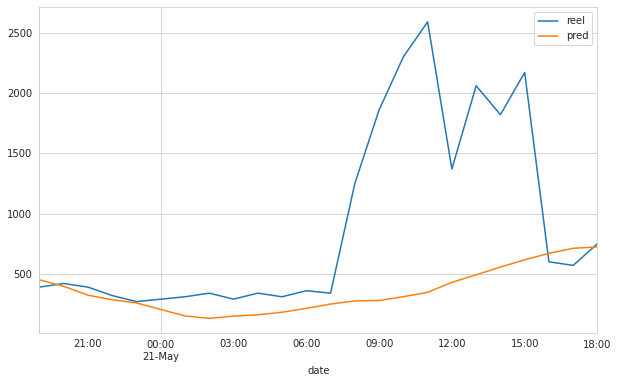

In [71]:
com.plot()

# Retrain and Forecast with Full Data

In [74]:
val_size=24
val=df.iloc[-val_size:]
full=df.iloc[:-val_size]
print(len(full),len(val))

3266 24


In [76]:
f_columns=df.columns[1:]
f_transformer=RobustScaler()
target_transform=RobustScaler()
full.loc[:,f_columns]=f_transformer.fit_transform(full[f_columns])
full["Appliances"]=target_transform.fit_transform(full[["Appliances"]])

val.loc[:,f_columns]=f_transformer.transform(val[f_columns])
val["Appliances"]=target_transform.transform(val[["Appliances"]])


In [77]:
full

,Appliances,lights,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,
2016-01-11 17:00:00,-0.111,10.500,0.547,-2.218,0.756,1.643,0.299,-1.041,1.047
2016-01-11 18:00:00,1.917,15.500,0.603,-2.167,0.537,0.000,0.229,-1.044,1.041
2016-01-11 19:00:00,1.861,7.500,0.620,-2.115,0.707,0.000,0.180,-0.911,1.415
2016-01-11 20:00:00,1.056,10.500,0.597,-2.066,0.707,0.000,0.113,-0.789,1.709
2016-01-11 21:00:00,0.694,7.000,0.582,-2.038,0.707,0.000,0.077,-0.639,1.469
...,...,...,...,...,...,...,...,...,...
2016-05-26 14:00:00,0.111,0.500,-1.029,0.057,-0.341,-1.500,0.989,1.663,0.074
2016-05-26 15:00:00,0.000,0.000,-1.029,0.037,-0.415,-1.000,1.107,1.651,0.040
2016-05-26 16:00:00,7.222,0.500,-1.029,0.013,-0.634,0.000,1.026,1.674,0.111


In [78]:
X,y=create(full,full.Appliances,time_steps)

In [79]:
model=Sequential()

model.add(Bidirectional(LSTM(units=100,input_shape=(time_steps,n_features))))

model.add(Dropout(rate=0.2))

model.add(Dense(1))

model.compile(optimizer="adam",loss="mse")

In [80]:
model.fit(X,y,epochs=15,batch_size=24)

Epoch 1/15
136/136 [==============================] - 11s 33ms/step - loss: 1.3532
Epoch 2/15
136/136 [==============================] - 5s 34ms/step - loss: 1.1262
Epoch 3/15
136/136 [==============================] - 5s 34ms/step - loss: 1.0870
Epoch 4/15
136/136 [==============================] - 4s 33ms/step - loss: 1.0607
Epoch 5/15
136/136 [==============================] - 5s 37ms/step - loss: 1.0129
Epoch 6/15
136/136 [==============================] - 5s 38ms/step - loss: 1.0240
Epoch 7/15
136/136 [==============================] - 5s 39ms/step - loss: 0.9959
Epoch 8/15
136/136 [==============================] - 5s 33ms/step - loss: 0.9557
Epoch 9/15
136/136 [==============================] - 4s 32ms/step - loss: 0.9473
Epoch 10/15
136/136 [==============================] - 4s 33ms/step - loss: 0.9173
Epoch 11/15
136/136 [==============================] - 4s 33ms/step - loss: 0.8965
Epoch 12/15
136/136 [==============================] - 4s 32ms/step - loss: 0.8799
Epoch 13/15


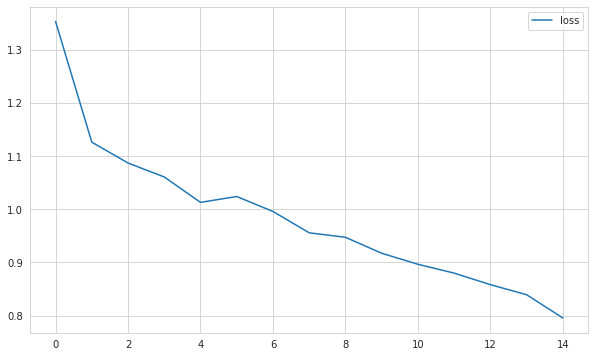

In [81]:
losses=pd.DataFrame(model.history.history)
losses.plot()

In [82]:
df_fake=val.iloc[:,1:]

In [83]:
reel=np.array(val.iloc[:,:1])
reel.reshape((1,-1))[0]

array([ 2.69444444,  0.5       ,  0.25      ,  0.13888889,  0.05555556,
       -0.02777778, -0.05555556, -0.19444444, -0.05555556, -0.05555556,
       -0.05555556,  0.02777778,  0.83333333,  1.13888889,  3.16666667,
        3.16666667,  4.13888889,  2.05555556,  3.38888889,  0.66666667,
        0.25      ,  1.22222222,  1.97222222,  0.16666667])

In [84]:
time_steps

24

In [85]:
forecast=[]
first_eval_batch=train.values[-time_steps:]
current_batch=first_eval_batch.reshape((1,time_steps,n_features))
features= df_fake.values.reshape((df_fake.shape[0],1,df_fake.shape[1]))

for i in range(time_steps):
  current_pred=model.predict(current_batch)
  forecast.append(current_pred[0])
  new=features[i][0].tolist()
  new.insert(0,current_pred[0][0])
  new=np.array(new).reshape(1,1,n_features)
  current_batch=np.append(current_batch[:,1:,:],new,axis=1)

In [89]:
ev_metrics(reel.reshape((1,-1))[0],forecast)

r2_score -0.28861841634901 mae: 2.233283487074771 rmse: 1.4944174407021522


In [90]:
forecast1=target_transform.inverse_transform(np.array(forecast).reshape(1,-1))

In [91]:
forecast_index=pd.date_range(start="2016-05-26 19:00:00",periods=time_steps,freq="H")

In [93]:
forecast_df=pd.DataFrame(data=forecast1.reshape(-1,1),index=forecast_index,columns=["forecast"])

In [94]:
forecast_df

,forecast
2016-05-26 19:00:00,467.787
2016-05-26 20:00:00,422.103
2016-05-26 21:00:00,475.357
2016-05-26 22:00:00,520.347
2016-05-26 23:00:00,567.827
2016-05-27 00:00:00,510.971
2016-05-27 01:00:00,403.556
2016-05-27 02:00:00,305.929
2016-05-27 03:00:00,275.963
2016-05-27 04:00:00,288.844


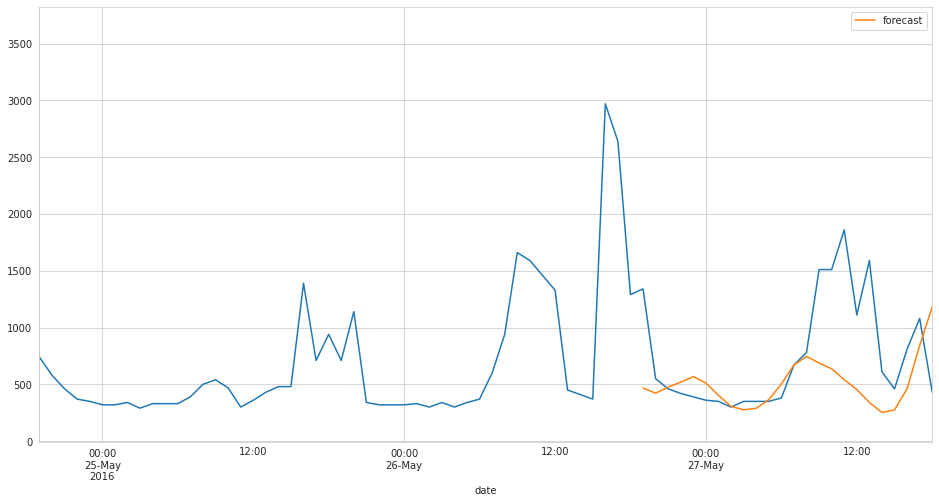

In [97]:
ax=df["Appliances"].plot()
forecast_df.plot(ax=ax,figsize=(16,8))
plt.xlim("2016-05-24 19:00:00","2016-05-27 18:00:00");